In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import pyLDAvis
import pyLDAvis.sklearn

import re
from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction import stop_words as sklearn_stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim import matutils
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import pickle
from pymongo import MongoClient
from bson import json_util

In [2]:
%matplotlib inline
pyLDAvis.enable_notebook()
# custom_style = {'axes.labelcolor': 'white',
#                 'xtick.color': 'white',
#                 'ytick.color': 'white'}
# sns.set_style("darkgrid", rc=custom_style)

### Presidents List

In [3]:
pres_list = pd.read_csv('https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv')

### JSON-Pandas Stuff

In [4]:
json_file = '/home/cneiderer/Downloads/presidency.json'

In [5]:
# Load presidential json data into df
pres_df = pd.read_json(json_file)
# Convert from wide to long format
pres_df = pres_df.T
# Subset data on oral and written speeches
pres_df = pres_df[['Oral', 'Written']]

In [6]:
# Transform into more usable format
df = pd.DataFrame()
for idx in tnrange(len(pres_df.index)):
    pres = pres_df.index[idx]
    pres_data = pres_df.loc[pres]
    
    speech_type = ['Oral', 'Written']
    for jdx in tnrange(len(speech_type)):
        tmp_df = pd.DataFrame.from_dict(pres_df.loc[pres][speech_type[jdx]])
        tmp_df.insert(0, 'President', pres)
        tmp_df.insert(1, 'Type', speech_type[jdx])
        try:
            tmp_df.document_date = pd.to_datetime(tmp_df.document_date)
        except:
            tmp_df.document_data = pd.to_datetime('20500101')
        df = pd.concat([df, tmp_df], axis=0)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58595 entries, 0 to 48
Data columns (total 8 columns):
President        58595 non-null object
Type             58595 non-null object
category         58595 non-null object
content          58595 non-null object
document_date    58595 non-null datetime64[ns]
pid              58595 non-null float64
subcategory      41464 non-null object
title            58595 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.0+ MB


### Clean Corpus

In [8]:
corpus = df['content']

In [9]:
len(corpus)

58595

In [10]:
# clean and stem presidential addresses
clean_corpus = []
punctuation = re.compile(r"[!#$%&\'\"()\*\+,-\./:;<=>\?@\[\\\]^_`{\|}~]")
# house_senate_opening = re.compile('''to\s+the\s+(?:senate|house\s+of\s+representatives|)
#                                      (\s+and\s+)*(?:senate|house\s+of\s+representatives|house)*''')
for doc in corpus:
    temp = doc.lower()
    temp = re.sub(r'\n', ' ', temp)
    temp = re.sub(r'united\s+states', ' ', temp)
    temp = re.sub(r'mr.\s+(vice)?president', ' ', temp)
    temp = re.sub(r'(?:mr\.|madam)\s+speaker', ' ', temp)
    temp = re.sub(r'americaa', 'america', temp)
    temp = re.sub(r'special\s+message', ' ', temp)
    temp = re.sub(r'executive\s+order', ' ', temp)
    temp = re.sub(r'statement\s+on\s+the', ' ', temp)
    temp = re.sub(r'section\s+\d+', ' ', temp)
#     temp = re.sub(house_senate_opening, temp)
    temp = re.sub(r'[^A-Za-z]+', ' ', temp)
    temp = re.sub(punctuation, ' ', temp)
    
#     temp = word_tokenize(temp)
#     lemma = []
#     for word in temp:
#         lemma.append(stemmer.stem(word))
#     temp = ' '.join(clean_corpus[0])
    
    clean_corpus.append(temp)
    
len(clean_corpus)

58595

In [11]:
# Combine Sklearn and NLTK English stop words
months_list = ['january', 'jan', 'february', 'feb', 'march', 'mar', 'april', 'apr', 'may', 'june', 'jun', 
               'july', 'jul', 'august', 'aug', 'september', 'sept', 'october', 'oct', 'november', 'nov', 'december', 'dec']
custom_stopwords = ['hereunto', 'whereof', 'thereof', 'nineteen', 'said', 'herewith', 'shall', 'say', 'like',
                    'mr', 'mrs', 'sir', 'dear', 'george', 'bush', 'william', 'thirty', 'lot', 'want', 'let', 'clinton',
                    'sure', 'way', 'section', 'act', 'answer', 'laughter', 'great', 'good', 'things', 'thing',
                    'going', 'know', 'day', 'new', 'make', 'got', 'yes', 'year', 'week', 'sec', 'obama', 'john'] + months_list

stopwords = sklearn_stopwords.ENGLISH_STOP_WORDS \
            .union(nltk_stopwords.words('english')) \
            .union(gensim_stopwords) \
            .union(custom_stopwords)

In [12]:
# Helper Function
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]), '\n')
    print()

In [20]:
n_features = 1000
n_topics = 20
n_top_words = 20
seed = 129

In [ ]:
tf_vectorizer = CountVectorizer(ngram_range=(1, 2), 
                                   min_df=0.02, 
                                   max_df=0.8,
                                   max_features=n_features, 
                                   stop_words=stopwords,
                                   token_pattern=r'\b[a-zA-Z]{3,}\b')
dtm_tf = tf_vectorizer.fit_transform(clean_corpus)
print(dtm_tf.shape)

In [ ]:
lda_tf = LatentDirichletAllocation(n_components=n_topics,                           
                                   n_jobs=-1,
                                   random_state=seed)
lda_tf.fit(dtm_tf)

In [ ]:
reduced = lda_tf.fit_transform(dtm_tf)

In [ ]:
h = pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

In [ ]:
# pickle LDA results
pickle_file = 'APP_lda_results.pickle'
data = {'tf_vectorizer': tf_vectorizer, 
        'dtm_tf': dtm_tf,
        'lda_tf': lda_tf,
        'lda_tm': reduced,
        'lda_vis': h}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

In [ ]:
pickle_file = 'APP_lda_results.pickle'
with open(pickle_file, 'rb') as f:
    tmp = pickle.load(f)
tmp.keys()

In [15]:
tf_vectorizer = tmp['tf_vectorizer']
dtm_tf = tmp['dtm_tf']
lda_tf = tmp['lda_tf']
lda_tm = tmp['lda_tm']
lda_vis = tmp['lda_vis']

In [16]:
lda_tf.components_.shape

(20, 1000)

In [22]:
# Helper Function to pull out top words associated with topic
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i] for i in topic.argsort()[:-n_top_words-1:-1]]), '\n')
    print()

In [23]:
tf_feature_names = tf_vectorizer.get_feature_names()
print_top_words(lda_tf, tf_feature_names, n_top_words)

Topic #0:
think president time question people believe problem hope course come fact meeting point situation israel press questions conference secretary kind 

Topic #1:
world trade economic countries nations international nuclear soviet foreign agreement policy american cooperation security free development europe union peace progress 

Topic #2:
children education white house school white schools house child young students parents young people help family families lord learn america welfare communities 

Topic #3:
agency commission federal department executive information office director law president government council management security enforcement departments order functions policy review 

Topic #4:
board united general nations united nations attorney attorney general labor court district iran international council justice settlement organization resolution member members york 

Topic #5:
congress program federal government budget million billion increase percent fiscal legislat

In [25]:
component_dicts = []

components = lda_tf.components_
for index,values in enumerate(components):
    print("topic {}".format(index))
    temp = list(zip(tf_feature_names, components[index]))
    print(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words], "\n")
    
    component_dicts.append(dict(sorted(temp, key=lambda x: x[1], reverse=True)[:n_top_words]))

topic 0
[('think', 50332.5686769678), ('president', 32788.880976601744), ('time', 14678.270575188), ('question', 13868.105237403759), ('people', 13000.01609912805), ('believe', 12022.907111433784), ('problem', 8055.3299149964569), ('hope', 7836.8140253571282), ('course', 7634.7835636963791), ('come', 7404.6738392433454), ('fact', 6856.0312444093834), ('meeting', 6837.6559572450597), ('point', 6746.3840916800118), ('situation', 6647.7934506631673), ('israel', 6589.0380309497077), ('press', 6569.3232439942876), ('questions', 6268.2241665397123), ('conference', 6234.0434064548872), ('secretary', 6141.1209985244595), ('kind', 6130.5844568066095)] 

topic 1
[('world', 26003.00115687252), ('trade', 23305.697933122708), ('economic', 22580.72084414677), ('countries', 21978.69552914433), ('nations', 19059.879130395817), ('international', 18947.201922705794), ('nuclear', 14189.848423760639), ('soviet', 13569.504578591674), ('foreign', 11768.24091135309), ('agreement', 11361.333617314649), ('poli

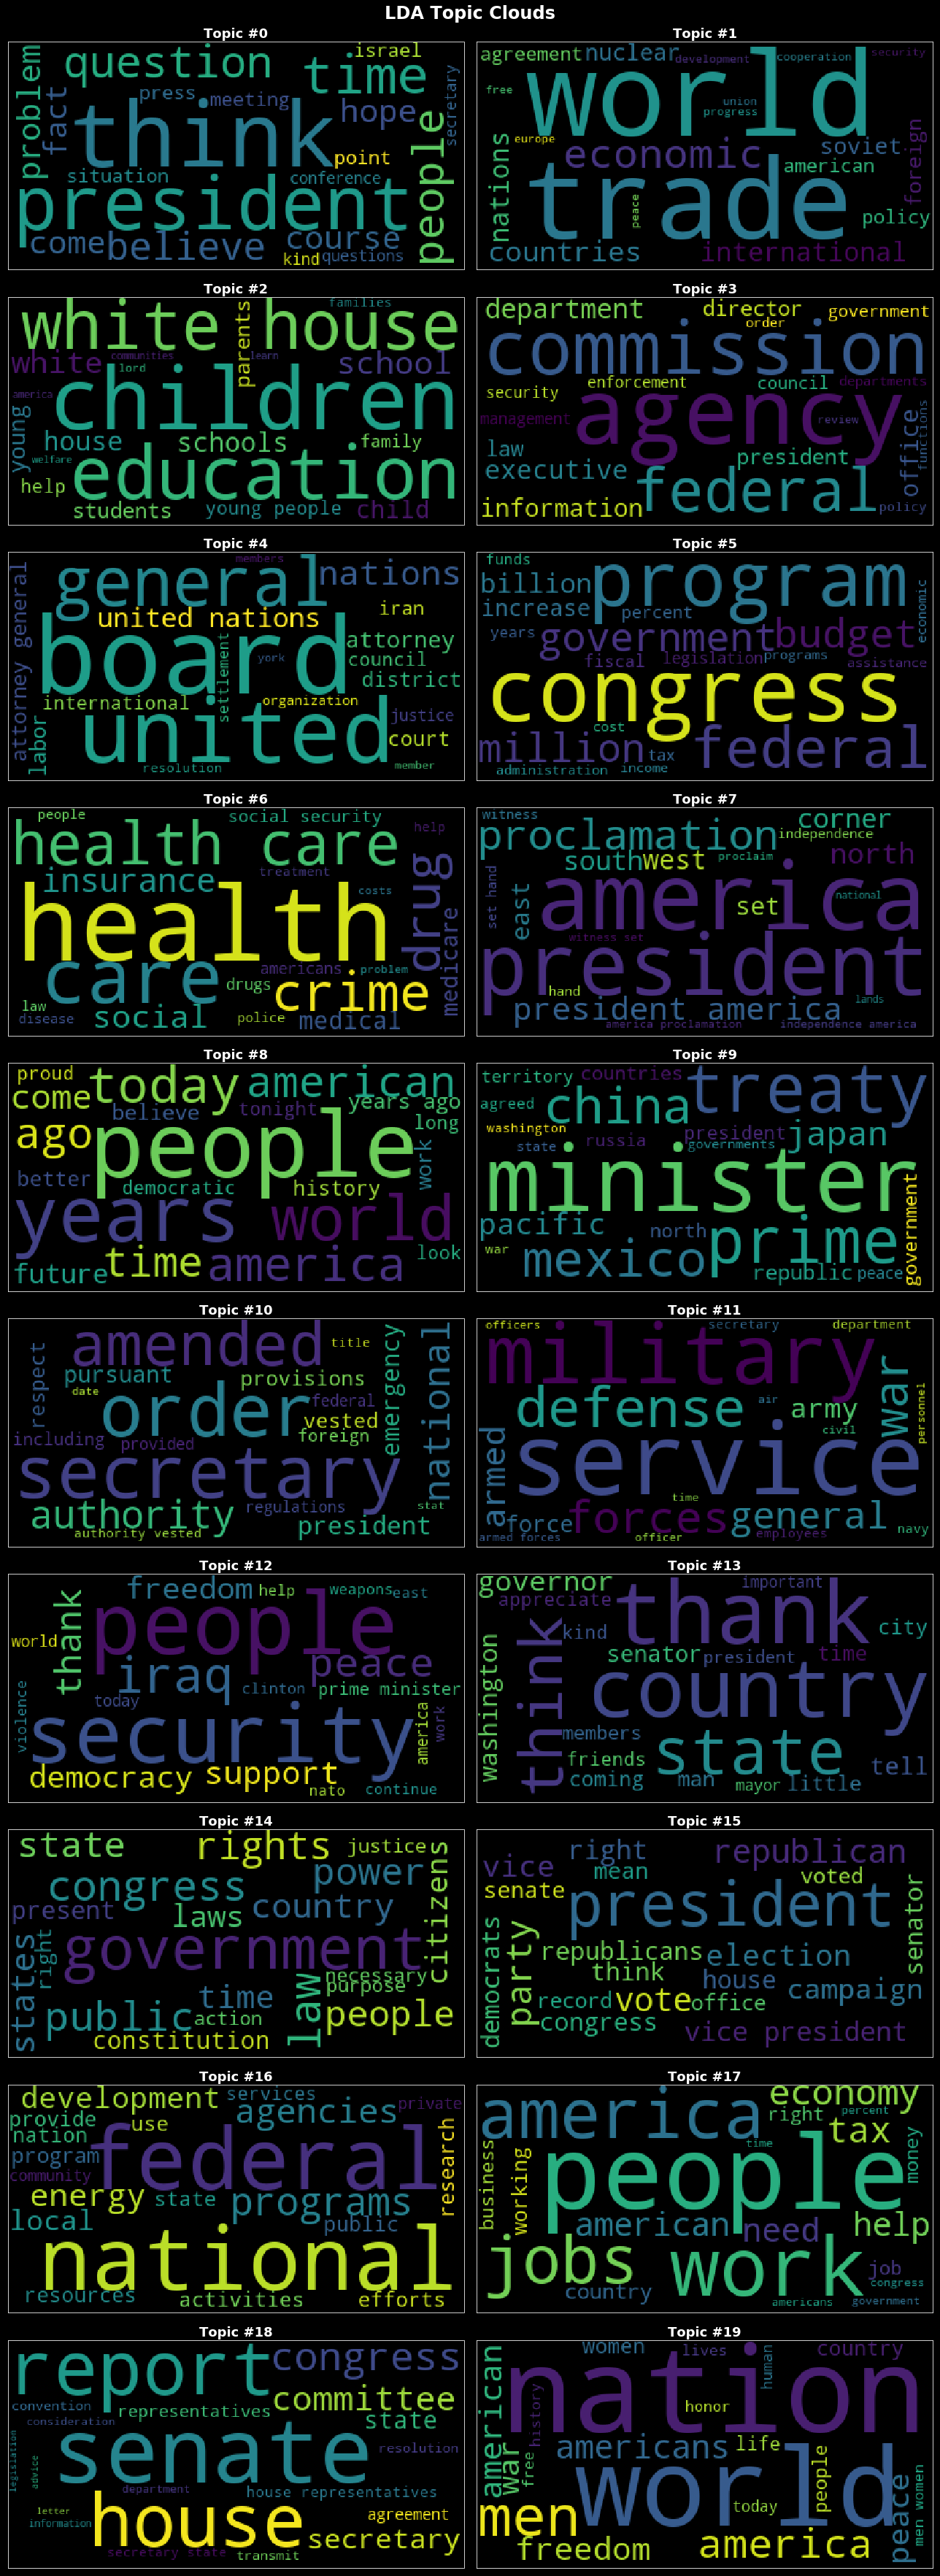

In [26]:
# Create topic word clouds
plt.style.use('dark_background')

ncol = 2
nrow = int(np.ceil(len(component_dicts) / ncol))

figwidth = ncol * 9
figheight = nrow * 5
fig, axes = plt.subplots(nrow, ncol, figsize=(figwidth, figheight))
ax = axes.flatten()

num_words = 20 # Number of words to include in word cloud
for t in range(len(component_dicts)): 
#     plt.sca(ax[t])  
    curr_ax = fig.sca(ax[t])
    curr_ax.set_title('Topic #%d' % t, fontsize=18, fontweight='bold')
    curr_ax.set_xticks([])
    curr_ax.set_yticks([])
#     curr_ax.set_axis_on(0)    
    plt.imshow(WordCloud().fit_words(component_dicts[t]))
    
fig.tight_layout(rect=(0, 0, 1, 0.975))
fig.suptitle('LDA Topic Clouds', fontsize=24, fontweight='bold');

In [29]:
# try out a range of cluster sizes to find the one with the best inertia and silhouette scores
inertias = []
silhouettes = []
n_clusters = np.arange(3, 45, 3)
for n in tnrange(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[n], init="k-means++", random_state=seed)
    kmeans.fit(lda_tm)
    
    inertias.append(kmeans.inertia_)
    
    # only a sample was used to calculate silhouette score because of memory errors
    labels = kmeans.labels_
    silhouettes.append(silhouette_score(lda_tm, labels, metric='euclidean', sample_size=10000, random_state=seed))

A Jupyter Widget

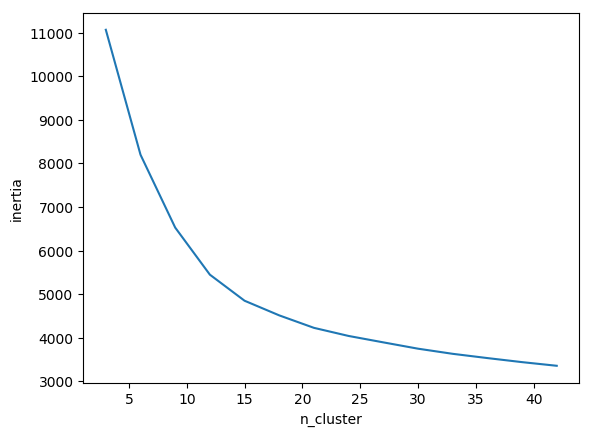

In [30]:
# plot the inertia scores and look for the kink in the curve
plt.style.use('default')
plt.plot(n_clusters, inertias)
plt.xlabel('n_cluster')
plt.ylabel('inertia');

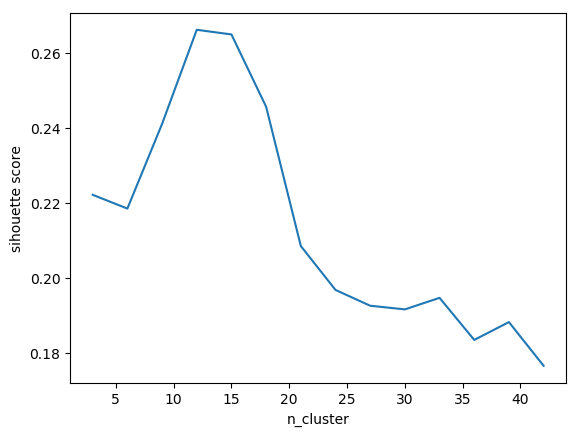

In [31]:
# plot the silhouettte scores
plt.style.use('default')
plt.plot(n_clusters, silhouettes)
plt.xlabel('n_cluster')
plt.ylabel('sihouette score');

In [34]:
kmeans = KMeans(n_clusters=15, init="k-means++", random_state=seed)
kmeans.fit(lda_tm)
labels = kmeans.labels_
print("Inertia score: {}".format(kmeans.inertia_))

silhouette = silhouette_score(lda_tm, 
                              labels, 
                              metric='euclidean', 
                              sample_size=10000, 
                              random_state=seed)
print("Silhouette score: {}".format(silhouette))

Inertia score: 4850.576287463096
Silhouette score: 0.2648750776667549


### TSNE Dimension Reduction and Visualization

#### 2 Dimensions

In [ ]:
tsne = TSNE(n_components=2, perplexity=50, n_iter=500, random_state=seed)
tsne_reduced = tsne.fit_transform(lda_tm)

In [ ]:
tsne_reduced.shape

In [ ]:
df_tsne_reduced = pd.DataFrame(tsne_reduced, columns=["tsne_x", "tsne_y"])
df_tsne_reduced.shape

In [ ]:
df_tsne_reduced['Cluster'] = labels
df_tsne_reduced.info()

In [ ]:
# pickle TSNE results
pickle_file = 'APP_lda_20topic_tsne_results.pickle'
data = {'tsne_reduced': tsne_reduced, 
        'df_tsne_reduced': df_tsne_reduced}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

In [ ]:
groups = df_tsne_reduced.groupby('Cluster')

In [ ]:
colors = pd.read_csv('/home/cneiderer/Documents/20distinctcolors.csv', header=None)
cmap = colors.iloc[:, 1]

In [ ]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(10, 8))
cidx = 0
for name, group in groups:
    ax.plot(group.tsne_x, group.tsne_y, marker='o', linestyle='', ms=2, alpha=0.2, label=name, color=cmap[cidx])
    cidx += 1
ax.set_xticks([])
ax.set_yticks([])
ax.set_facecolor('k')
label_strings = ['Topic #%d' % x for x in set(labels)]

# leg = ax.legend(loc='upper right')
leg = ax.legend(label_strings, loc=9, bbox_to_anchor=(1.1, 1), 
                labelspacing=1, borderpad=1)
leg.get_frame().set_facecolor('k')
leg.get_frame().set_color('k')
for text in leg.get_texts():
    text.set_color('w')
    text.set_fontsize(11)
    text.set_fontweight('bold')

for lh in leg.legendHandles: 
    lh._legmarker.set_alpha(1)
    lh._legmarker.set_markersize(10)

#### 3 Dimensions

In [37]:
tsne3 = TSNE(n_components=3, perplexity=50, n_iter=500, random_state=seed)
tsne3_reduced = tsne3.fit_transform(lda_tm)

In [40]:
tsne3_reduced.shape

(58595, 3)

In [41]:
df_tsne3_reduced = pd.DataFrame(tsne3_reduced, columns=["tsne_x", "tsne_y", "tsne_z"])
df_tsne3_reduced.shape

(58595, 3)

In [42]:
df_tsne3_reduced['Cluster'] = labels
df_tsne3_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58595 entries, 0 to 58594
Data columns (total 4 columns):
tsne_x     58595 non-null float32
tsne_y     58595 non-null float32
tsne_z     58595 non-null float32
Cluster    58595 non-null int32
dtypes: float32(3), int32(1)
memory usage: 915.6 KB


In [43]:
# pickle TSNE3 results
pickle_file = 'APP_lda_20topic_tsne3_results.pickle'
data = {'tsne3_reduced': tsne3_reduced, 
        'df_tsne3_reduced': df_tsne3_reduced}
with open(pickle_file, 'wb') as f:
    pickle.dump(data, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)